## Final Project NLP
### _From Words to Feelings: Multi-Class Emotion Detection in Text Data_

In [2]:
import sys
print(sys.executable)
print(sys.version)


c:\Users\asusn\anaconda3\envs\nlp\python.exe
3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tag import pos_tag
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier, accuracy
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

In [5]:
# !curl -L -o emotion.zip https://www.kaggle.com/api/v1/datasets/download/parulpandey/emotion-dataset

# import zipfile
# import os

# dataset_path = "/content/emotion.zip"
# extract_path = "/content/emotion"

# with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# import pandas as pd

# train = pd.read_csv("/content/emotion/training.csv")
# test = pd.read_csv("/content/emotion/test.csv")
# valid = pd.read_csv("/content/emotion/validation.csv")

# train.head()


In [2]:
train = pd.read_csv('dataset/training.csv')
test = pd.read_csv('dataset/test.csv')
valid = pd.read_csv('dataset/validation.csv')

EDA Analysis

In [3]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['description'] = train['label'].map(labels_dict)
train.head()
# test.head()
# valid.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [4]:
train.isnull().sum()
train.info()
train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         16000 non-null  object
 1   label        16000 non-null  int64 
 2   description  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


,text,label,description
count,16000,16000.000000,16000
unique,15969,NaN,6
top,i feel on the verge of tears from weariness i ...,NaN,joy
freq,2,NaN,5362
mean,NaN,1.565937,NaN
std,NaN,1.501430,NaN
min,NaN,0.000000,NaN
25%,NaN,0.000000,NaN
50%,NaN,1.000000,NaN
75%,NaN,3.000000,NaN


Jumlah setiap label:
             Count Percentage
description                  
joy           5362     33.51%
sadness       4666     29.16%
anger         2159     13.49%
fear          1937     12.11%
love          1304      8.15%
surprise       572      3.57%


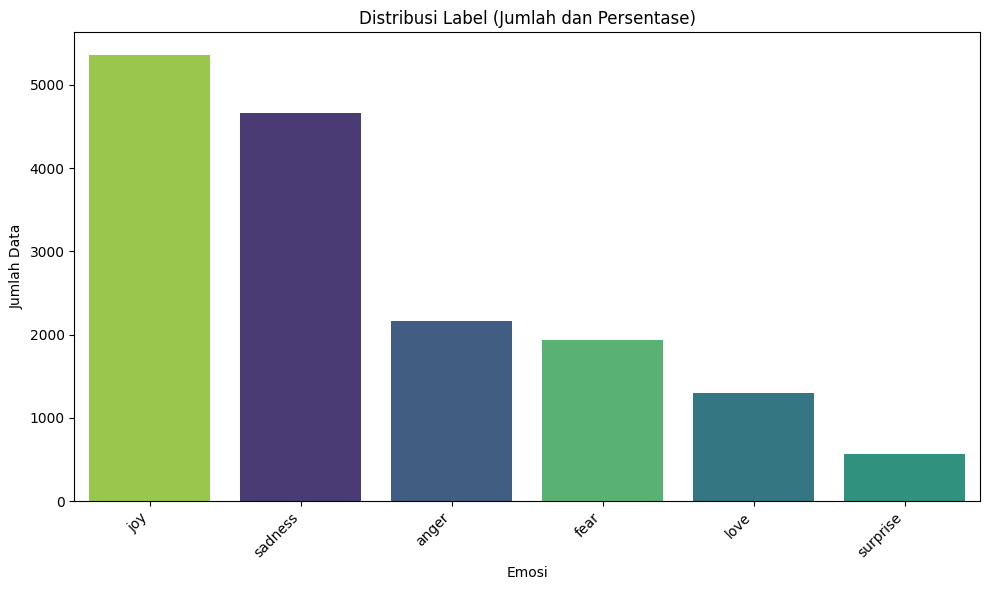

In [5]:

print("Jumlah setiap label:")
label_counts = train['description'].value_counts()
label_percentages = train['description'].value_counts(normalize=True) * 100

combined_df = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percentages.map('{:.2f}%'.format)
})
print(combined_df)

plt.figure(figsize=(10, 6))
sns.countplot(x='description', data=train, order=label_counts.index, palette='viridis', hue='description', legend=False) # Addressed FutureWarning
plt.title("Distribusi Label (Jumlah dan Persentase)")
plt.xlabel("Emosi")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

--- Text Length Analysis (in words) ---
count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000


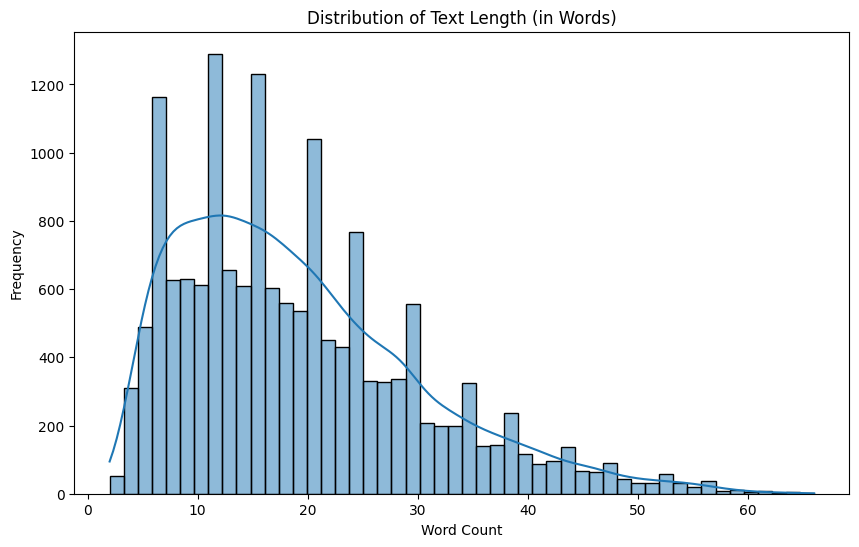

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

def simple_word_count(text):
    words = re.findall(r'\b\w+\b', str(text).lower())
    return len(words)

train['word_count'] = train['text'].apply(simple_word_count)

# Descriptive statistics
print("--- Text Length Analysis (in words) ---")
print(train['word_count'].describe().to_string())

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['word_count'], bins=50, kde=True)
plt.title('Distribution of Text Length (in Words)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('word_count_distribution.png')
plt.show()



--- Top 10 Unigrams (Raw) ---
i: 25859
feel: 11183
and: 9589
to: 8972
the: 8370
a: 6200
feeling: 5112
that: 5112
of: 4990
my: 4283


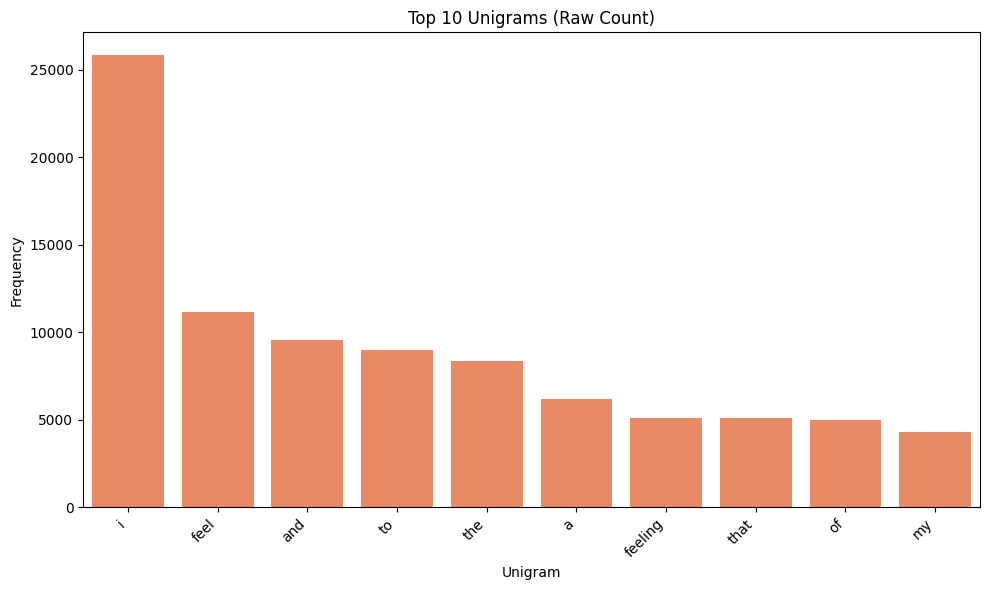

In [7]:

# --- Prepare Tokens for Frequency Analysis ---
all_text = ' '.join(train['text'].values)
cleaned_tokens = re.findall(r'\b\w+\b', all_text.lower())

# --- 2. Word Frequency (Unigram) ---
unigram_counts = Counter(cleaned_tokens)
top_10_unigrams = unigram_counts.most_common(10)

print("\n--- Top 10 Unigrams (Raw) ---")
for word, count in top_10_unigrams:
    print(f"{word}: {count}")

# Plotting Top 10 Unigrams
words, counts = zip(*top_10_unigrams)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts), color='coral')
plt.title('Top 10 Unigrams (Raw Count)')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_10_unigrams.png')
plt.show()

In [8]:
def generate_ngrams(tokens, n=2):
    # Function untuk membuat N-grams
    return zip(*[tokens[i:] for i in range(n)])

bigrams_list = [' '.join(gram) for gram in generate_ngrams(cleaned_tokens, 2)]
bigram_counts = Counter(bigrams_list)
top_10_bigrams = bigram_counts.most_common(10)

print("\n--- Top 10 Bigrams (Raw) ---")
for bigram, count in top_10_bigrams:
    print(f"{bigram}: {count}")

# --- 4. Analysis of Punctuation/Emotive Characters ---
train['exclamation_count'] = train['text'].apply(lambda x: str(x).count('!'))
train['question_count'] = train['text'].apply(lambda x: str(x).count('?'))

print("\n--- Emotive Punctuation Analysis ---")
print(f"Total Exclamation Marks ('!'): {train['exclamation_count'].sum()}")
print(f"Total Question Marks ('?'): {train['question_count'].sum()}")


--- Top 10 Bigrams (Raw) ---
i feel: 6997
i am: 1936
feel like: 1744
i was: 1322
that i: 1280
i have: 1136
and i: 1062
im feeling: 801
to be: 785
to feel: 762

--- Emotive Punctuation Analysis ---
Total Exclamation Marks ('!'): 0
Total Question Marks ('?'): 0


Pre processing

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asusn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asusn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\asusn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [10]:
stopwords_eng = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "V": wordnet.VERB,
        "N": wordnet.NOUN,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_base(text):
    # Lowercase
    text = text.lower()

    # Remove URL
    text = re.sub(r"http\S+|www\S+","", text)

    # Remove username/mention
    text = re.sub(r"@\w+","", text)

    # Remove hashtag symbol (#love → love)
    text = re.sub(r"#","", text)

    # Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z\s]","", text)

    # Tokenize
    tokens = text.split()

    # Remove stopword
    tokens = [w for w in tokens if w not in stopwords_eng]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(w, get_pos(w)) for w in tokens]


    # Join back to string
    return " ".join(tokens)

def preprocess_bert(text):
  text = str(text).lower()
  return text.strip()


---

# Base model

In [ ]:
train['clean_text'] = train['text'].astype(str).apply(preprocess_base)
train.head()


In [ ]:
# Cell A1: requirements (run once)
# !pip install scikit-learn imbalanced-learn matplotlib seaborn  # uncomment to install if needed

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- CONFIG ----------
RANDOM_STATE = 42
TEST_SIZE = 0.2
# ----------------------------

assert 'text' in train.columns and 'label' in train.columns, "DataFrame must have 'text' and 'label' columns"

# quick label distribution check
print("Label distribution:\n", train['label'].value_counts())

# Cell A3: train/test split (stratified)
X = train['text'].astype(str)
y = train['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Cell A4: vectorize (TF-IDF)
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=3)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Cell A5: SMOTE on TRAIN only (important)
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

print("After SMOTE, label distribution:\n", pd.Series(y_train_res).value_counts())

# Cell A6: train a classifier (Logistic Regression)
clf = LogisticRegression(max_iter=2000, class_weight=None, random_state=RANDOM_STATE, n_jobs=-1)
clf.fit(X_train_res, y_train_res)

# Cell A7: evaluate
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# Optional: try RandomForest or XGBoost similarly
# rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
# rf.fit(X_train_res, y_train_res)
# ... evaluate as above


In [ ]:
X_new = valid['text'].astype(str)
y_new = valid['label']

print("X_new head:")
print(X_new.head())
print("\ny_new head:")
print(y_new.head())

In [ ]:
X_new_tfidf = vectorizer.transform(X_new)

print("Shape of X_new_tfidf:", X_new_tfidf.shape)

In [ ]:
y_pred_new = clf.predict(X_new_tfidf)

print("First 10 predictions on validation set:")
print(y_pred_new[:10])

In [ ]:
print("Accuracy on validation set:", accuracy_score(y_new, y_pred_new))
print("Macro F1 on validation set:", f1_score(y_new, y_pred_new, average='macro'))
print("\nClassification report on validation set:\n", classification_report(y_new, y_pred_new))

# Confusion matrix plot for validation set
cm_new = confusion_matrix(y_new, y_pred_new, labels=np.unique(y_new))
plt.figure(figsize=(6,5))
sns.heatmap(cm_new, annot=True, fmt='d', xticklabels=np.unique(y_new), yticklabels=np.unique(y_new))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix on Validation Set')
plt.show()

---


Transformers - based

In [15]:
%pip install evaluate
%pip install validation

   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   -------------------------------- ------- 2.4/2.9 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 11.3 MB/s  0:00:00
   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
   -- ------------------------------------- 2.1/28.0 MB 11.8 MB/s eta 0:00:03
   ----- ---------------------------------- 4.2/28.0 MB 10.1 MB/s eta 0:00:03
   -------- ------------------------------- 5.8/28.0 MB 9.5 MB/s eta 0:00:03
   ---------- ----------------------------- 7.1/28.0 MB 8.4 MB/s eta 0:00:03
   ----------- ---------------------------- 8.4/28.0 MB 8.1 MB/s eta 0:00:03
   ------------- -------------------------- 9.7/28.0 MB 7.8 MB/s eta 0:00:03
   --------------- ------------------------ 10.7/28.0 MB 7.3 MB/s eta 0:00:03
   ---------------- ----------------------- 11.3/28.0 MB 6.7 MB/s eta 0:00:03
   ----------------- ---------------------- 12.6/28.0 MB 6.6 MB/s eta 0:00:03
   ---------

In [16]:
%pip install transformers datasets evaluate scikit-learn accelerate --quiet
# upgrade to a modern transformers + datasets + accelerate
%pip install -U transformers datasets accelerate evaluate --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [17]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Cell 0: (uncomment to install if needed)
# !pip install transformers datasets evaluate scikit-learn accelerate --quiet

# Cell 1: imports
import os
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch
import evaluate

# Cell 2: configure column names & model
TEXT_COL = "text"
LABEL_COL = "label"
MODEL_NAME = "nateraw/bert-base-uncased-emotion"   # chosen by you
OUTPUT_DIR = "./bert_nateraw_emotion"
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 3
RANDOM_STATE = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Replace below with your actual data objects if they are not named train/validation/test ===
# train, validation, test  # assumed available as pandas DataFrames

# Quick checks
for name, df in [("train", train), ("valid", valid), ("test", test)]:
    assert isinstance(df, pd.DataFrame), f"{name} must be a pandas DataFrame"
    assert TEXT_COL in df.columns and LABEL_COL in df.columns, f"{name} must contain '{TEXT_COL}' and '{LABEL_COL}' columns"

# Cell 3: Build label mapping (handles string labels or int labels)
# unique_labels = sorted(train[LABEL_COL].unique(), key=lambda x: str(x))
# label2id = {label: idx for idx, label in enumerate(unique_labels)}
# id2label = {idx: label for label, idx in label2id.items()}

# # Convert label column into integer ids in-place for datasets
# def map_labels(df):
#     df_copy = df.copy()
#     df_copy["label_id"] = df_copy[LABEL_COL].map(label2id)
#     return df_copy

# train_df = map_labels(train)
# val_df = map_labels(valid)
# test_df = map_labels(test)

# num_labels = len(label2id)
# print("Num labels:", num_labels)
# print("Label2id:", label2id)

# ---------- Replace Cell 3 + Cell 4 with this block ----------
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# 1) Inspect original unique labels in train (raw)
print("Raw unique labels (train):", pd.Series(train[LABEL_COL]).unique())

# 2) Build a stable label list (strings) and map to consecutive integers 0..K-1
#    We convert everything to string first to avoid numpy-type problems and to keep order deterministic.
label_list = list(pd.unique(train[LABEL_COL].astype(str)))
label2id = {lab: idx for idx, lab in enumerate(label_list)}
id2label = {idx: lab for lab, idx in label2id.items()}
num_labels = len(label2id)

print("Built label_list:", label_list)
print("label2id:", label2id)
print("id2label:", id2label)
print("num_labels:", num_labels)

# 3) Remap train/val/test to label_id using the new mapping
def map_labels_consecutive(df, label_col=LABEL_COL):
    df2 = df.copy()
    # convert original label to string (same normalization as above)
    df2["label_str"] = df2[label_col].astype(str)
    if not set(df2["label_str"]).issubset(set(label2id.keys())):
        missing = set(df2["label_str"]) - set(label2id.keys())
        raise ValueError(f"Found labels in dataframe not present in training label set: {missing}")
    df2["label_id"] = df2["label_str"].map(label2id)
    return df2.drop(columns=["label_str"])

train_df = map_labels_consecutive(train)
val_df   = map_labels_consecutive(valid)
test_df  = map_labels_consecutive(test)

# quick check: what unique label_ids are present in train
unique_y_train = np.unique(train_df["label_id"].to_numpy())
print("Unique label_id in train:", unique_y_train)


# 4) compute class weights using actual classes observed in y_train (robust)
classes_for_cw = np.arange(num_labels)  # expected classes 0..K-1
# but ensure that every value in y_train is within that range
if not set(unique_y_train).issubset(set(classes_for_cw)):
    # defensive fallback: use unique values from y_train directly
    print("Warning: y_train contains unexpected label ids; using unique(y_train) for compute_class_weight")
    classes_for_cw = np.sort(unique_y_train)

y_train_arr = train_df["label_id"].to_numpy()
class_weights_np = compute_class_weight(class_weight="balanced", classes=classes_for_cw, y=y_train_arr)

# If compute_class_weight returned weights for a subset of classes (classes_for_cw may be shorter),
# we expand to length num_labels by placing 0.0 for missing classes (rare) – though normally not needed.
full_class_weights = np.zeros(num_labels, dtype=float)
for i, cls in enumerate(classes_for_cw):
    full_class_weights[int(cls)] = class_weights_np[i]

class_weights = torch.tensor(full_class_weights, dtype=torch.float)
print("Class weights (per label id 0..K-1):", class_weights.numpy())
# ----------------------------------------------------------------

# # Cell 4: compute class weights (from train only)
# y_train = train_df["label_id"].to_numpy()
# class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(num_labels), y=y_train)
# class_weights = torch.tensor(class_weights, dtype=torch.float)
# print("Class weights:", class_weights.numpy())

# Cell 5: convert to HuggingFace datasets and tokenize
hf_train = Dataset.from_pandas(train_df[[TEXT_COL, "label_id"]])
hf_val = Dataset.from_pandas(val_df[[TEXT_COL, "label_id"]])
hf_test = Dataset.from_pandas(test_df[[TEXT_COL, "label_id"]])

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, padding="max_length", max_length=MAX_LENGTH)

hf_train = hf_train.map(preprocess, batched=True)
hf_val = hf_val.map(preprocess, batched=True)
hf_test = hf_test.map(preprocess, batched=True)

hf_train = hf_train.rename_column("label_id", "labels")
hf_val = hf_val.rename_column("label_id", "labels")
hf_test = hf_test.rename_column("label_id", "labels")

hf_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
hf_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
hf_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Cell 6: load model (num_labels set to your classes)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# Cell 7: custom Trainer to use class_weights
from transformers import Trainer

# class WeightedTrainer(Trainer):
#     def __init__(self, class_weights=None, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         if class_weights is None:
#             self.class_weights = None
#         else:
#             # store as tensor; will move to device at compute_loss time
#             self.class_weights = class_weights

#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get("labels")
#         outputs = model(input_ids=inputs.get("input_ids"),
#                         attention_mask=inputs.get("attention_mask"),
#                         labels=None)
#         logits = outputs.get("logits")
#         loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
#         loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss
# Replace the old WeightedTrainer with this robust version
from transformers import Trainer

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = None if class_weights is None else class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Robust compute_loss that accepts extra kwargs from Trainer (e.g. num_items_in_batch)
        and passes only valid kwargs to the model call.
        """
        # Move labels out (Trainer may have already moved tensors to device)
        labels = inputs.get("labels")

        # Build a model inputs dict but avoid passing labels (we compute loss manually)
        model_inputs = {k: v for k, v in inputs.items() if k not in ("labels",)}
        # Call model; this will return a ModelOutput with .logits (and possibly other keys)
        outputs = model(**model_inputs)
        logits = outputs.logits

        # Prepare class weights on correct device (if provided)
        if self.class_weights is not None:
            weight = self.class_weights.to(logits.device)
        else:
            weight = None

        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


# Cell 8: metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "macro_f1": f1}

# Cell 9: training arguments & trainer init
# training_args = TrainingArguments(
#     output_dir=OUTPUT_DIR,
#     # evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=BATCH_SIZE,
#     per_device_eval_batch_size=BATCH_SIZE,
#     num_train_epochs=EPOCHS,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model="macro_f1",
#     logging_dir=f"{OUTPUT_DIR}/logs",
#     logging_steps=100,
#     seed=RANDOM_STATE,
#     save_total_limit=3,
# )
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=100,
    seed=RANDOM_STATE,
    save_total_limit=3,
)


trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

# Cell 10: start training
trainer.train()

# Cell 11: evaluate on validation and test sets
print("Validation evaluation:")
val_res = trainer.evaluate(eval_dataset=hf_val)
print(val_res)

print("Test evaluation:")
test_res = trainer.evaluate(eval_dataset=hf_test)
print(test_res)

# Predictions + classification report
preds_output = trainer.predict(hf_test)
preds = np.argmax(preds_output.predictions, axis=1)
print("Classification report (test):")
print(classification_report(test_df["label_id"], preds, target_names=[str(id2label[i]) for i in range(num_labels)]))

# Confusion matrix
cm = confusion_matrix(test_df["label_id"], preds)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Save final model & tokenizer
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model saved to {OUTPUT_DIR}")


Raw unique labels (train): [0 3 2 5 4 1]
Built label_list: ['0', '3', '2', '5', '4', '1']
label2id: {'0': 0, '3': 1, '2': 2, '5': 3, '4': 4, '1': 5}
id2label: {0: '0', 1: '3', 2: '2', 3: '5', 4: '4', 5: '1'}
num_labels: 6
Unique label_id in train: [0 1 2 3 4 5]
Class weights (per label id 0..K-1): [0.5715102  1.2351397  2.0449898  4.6620045  1.3766993  0.49732688]


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asusn\.cache\huggingface\hub\models--nateraw--bert-base-uncased-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

C:\Users\asusn\AppData\Local\Temp\ipykernel_7560\14698318.py:181: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.634900
200,0.235200
300,0.308300
400,0.269800
500,0.319200
600,0.303500
700,0.367600
800,0.236600
900,0.206800
1000,0.254200


c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation evaluation:


c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.37839752435684204, 'eval_accuracy': 0.94, 'eval_macro_f1': 0.9140710543421355, 'eval_runtime': 274.6713, 'eval_samples_per_second': 7.281, 'eval_steps_per_second': 0.91, 'epoch': 3.0}
Test evaluation:


c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.4398076832294464, 'eval_accuracy': 0.925, 'eval_macro_f1': 0.8775745998136006, 'eval_runtime': 268.6876, 'eval_samples_per_second': 7.444, 'eval_steps_per_second': 0.93, 'epoch': 3.0}


c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification report (test):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       581
           3       0.93      0.91      0.92       275
           2       0.80      0.86      0.83       159
           5       0.73      0.71      0.72        66
           4       0.85      0.91      0.88       224
           1       0.96      0.94      0.95       695

    accuracy                           0.93      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000

Confusion matrix (rows=true, cols=pred):
[[564   6   1   0   8   2]
 [ 13 249   1   0  10   2]
 [  0   2 137   0   0  20]
 [  0   2   0  47  17   0]
 [  4   6   0  11 203   0]
 [  3   4  32   6   0 650]]
Model saved to ./bert_nateraw_emotion


---
testing new data

In [18]:
from datasets import Dataset

def predict_emotions(text_list, trainer, tokenizer):
    # Convert list to HF dataset
    ds = Dataset.from_dict({"text": text_list})

    # Tokenize
    def preprocess(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True)

    tokenized_ds = ds.map(preprocess, batched=True)
    tokenized_ds = tokenized_ds.remove_columns(["text"])

    # Predict
    outputs = trainer.predict(tokenized_ds)
    pred_ids = outputs.predictions.argmax(axis=-1)

    # Get mapping from model config
    id2label = trainer.model.config.id2label

    # Emotion meaning map
    emotion_names = {
        "0": "sadness",
        "1": "joy",
        "2": "love",
        "3": "anger",
        "4": "fear",
        "5": "surprise"
    }

    # Convert id → dataset label → emotion name
    final_preds = [emotion_names[id2label[i]] for i in pred_ids]

    return final_preds


In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_path = "./bert_nateraw_emotion"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

model.eval()

texts = [
    "no words can describe this love",
    "I love this!",
    "so happy for you",
    "never do that again",
    "i was so scared",
    "someone's passing never felt this heavy",
    "i wasn't expecting that at all, was a shocking turn of event"
]

results = predict_emotions(texts, trainer, tokenizer)
print(results)


Map:   0%|          | 0/7 [00:00<?, ? examples/s]

c:\Users\asusn\anaconda3\envs\nlp\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


['love', 'joy', 'joy', 'anger', 'fear', 'sadness', 'surprise']


In [34]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader

def normalize_id2label(raw_id2label):
    """Normalize model.config.id2label into int -> str mapping."""
    norm = {}
    for k, v in raw_id2label.items():
        # keys might be strings like "0" or ints; normalize to int keys and string values
        try:
            k_int = int(k)
        except Exception:
            k_int = k
        norm[int(k_int)] = str(v)
    return norm

def predict_emotions_from_saved(text_list, model_path, emotion_names, device="cpu", batch_size=16):
    """
    Predict emotion names using a saved HF model at model_path.
    - text_list: list[str]
    - model_path: local folder containing the saved model & tokenizer
    - emotion_names: mapping from dataset-label-string -> readable name, e.g. {"0":"sadness",...}
    """
    # Load tokenizer & model from local folder
    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
    model.to(device)
    model.eval()

    # Prepare HF Dataset (keeps your preprocessing style)
    ds = Dataset.from_dict({"text": text_list})

    def preprocess(batch):
        # same as your original: padding max_length, truncation True
        return tokenizer(batch["text"], padding="max_length", truncation=True)

    tokenized_ds = ds.map(preprocess, batched=True)
    tokenized_ds = tokenized_ds.remove_columns(["text"])
    tokenized_ds.set_format(type="torch", columns=["input_ids", "attention_mask"])  # keep only required columns

    # DataLoader for batching
    dl = DataLoader(tokenized_ds, batch_size=batch_size)

    # Normalize id2label from model config
    raw_id2label = getattr(model.config, "id2label", None)
    if raw_id2label is None:
        # fallback: identity strings '0'.. if config missing
        raw_id2label = {i: str(i) for i in range(model.config.num_labels)}
    id2label_map = normalize_id2label(raw_id2label)  # int -> dataset_label_str

    # Predict
    preds = []
    with torch.no_grad():
        for batch in dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            logits = out.logits  # (B, num_labels)
            probs = torch.softmax(logits, dim=-1)
            batch_pred_ids = torch.argmax(probs, dim=-1).cpu().numpy()  # model class indices 0..K-1

            for pid in batch_pred_ids:
                dataset_label_str = id2label_map.get(int(pid), str(pid))  # e.g. '5' or '3'
                emotion_name = emotion_names.get(dataset_label_str, dataset_label_str)
                preds.append(emotion_name)

    return preds

# --------------------------
# Example usage (exactly like your earlier code)
model_path = "./bert_nateraw_emotion"   # change if your saved folder is elsewhere

emotion_names = {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
}

texts = [
    "no words can describe this love",
    "I love this!",
    "so happy for you",
    "never do that again",
    "i was so scared",
    "someone's passing never felt this heavy",
    "i wasn't expecting that at all, was a shocking turn of event"
]

results = predict_emotions_from_saved(texts, model_path=model_path, emotion_names=emotion_names, device="cpu", batch_size=8)
print(results)


Map:   0%|          | 0/7 [00:00<?, ? examples/s]

['love', 'joy', 'joy', 'anger', 'fear', 'sadness', 'surprise']
